
# Model Training and Evaluation

This notebook is designed to train and evaluate models on preprocessed data. It includes the following steps:
1. Splitting the dataset into training and testing subsets (manual implementation).
2. Training three models from Scikit-learn and two models from other libraries (e.g., XGBoost, LightGBM).
3. Selecting appropriate metrics based on the problem (classification or regression).
4. Manually implementing two of the chosen metrics.
5. Comparing the results and selecting the best model.


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv("../data/processed/scaled_results/Employee_MedianMode_imputed_standard_scaled.csv")

X = data.drop(columns=['LeaveOrNot'])
y = data['LeaveOrNot'].astype(int)

data.head()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Masters,Education_PHD,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,-0.027091,0.502502,-0.271910,0.064514,-0.664417,False,False,False,False,True,False
1,-1.157619,-3.185417,-0.271910,0.064514,1.505079,False,False,False,True,False,False
2,-0.592355,0.502502,1.901592,-0.608547,-0.664417,False,False,True,False,False,False
3,0.538173,0.502502,-0.489260,1.410638,1.505079,True,False,False,False,True,False
4,1.103437,0.502502,-1.141310,-0.608547,1.505079,True,False,False,True,True,True


In [51]:
def manual_train_test_split(X, y, test_size=0.2, random_state=10):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=10)

In [52]:
def manual_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def manual_f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(random_state=10),
    "Random Forest": RandomForestClassifier(random_state=10),
    "SVM": SVC(random_state=10),
    "XGBoost": XGBClassifier(random_state=10, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=10)
}

voting_clf = VotingClassifier(estimators=[
    ('lr', models["Logistic Regression"]),
    ('rf', models["Random Forest"]),
    ('svc', models["SVM"])
], voting='hard')  # Hard voting
models["Voting Classifier"] = voting_clf

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('rf', models["Random Forest"]),
        ('svc', models["SVM"])
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
models["Stacking Classifier"] = stacking_clf

# Manual cross-validation
def manual_cross_validation(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    accuracies, f1_scores = [], []
    
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        
        acc = manual_accuracy(y_test_cv, y_pred_cv)
        f1 = manual_f1_score(y_test_cv, y_pred_cv)
        
        accuracies.append(acc)
        f1_scores.append(f1)
    
    return {"Mean Accuracy": np.mean(accuracies), "Mean F1 Score": np.mean(f1_scores)}

results = {}
for name, model in models.items():
    results[name] = manual_cross_validation(model, X, y, n_splits=5)

# Display results
results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1124, number of negative: 2598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 3722, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301988 -> initscore=-0.837848
[LightGBM] [Info] Start training from score -0.837848
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1149, number of negative: 2573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

{'Logistic Regression': {'Mean Accuracy': 0.7635935460771746,
  'Mean F1 Score': 0.5157760714544664},
 'Random Forest': {'Mean Accuracy': 0.8486984742963399,
  'Mean F1 Score': 0.7341267256559056},
 'SVM': {'Mean Accuracy': 0.8564378688657126,
  'Mean F1 Score': 0.7246373198782592},
 'XGBoost': {'Mean Accuracy': 0.8590168970814134,
  'Mean F1 Score': 0.7443267291138873},
 'LightGBM': {'Mean Accuracy': 0.8676109628910987,
  'Mean F1 Score': 0.7569325696604731},
 'Voting Classifier': {'Mean Accuracy': 0.859660210433919,
  'Mean F1 Score': 0.7360488465605852},
 'Stacking Classifier': {'Mean Accuracy': 0.8665382349883928,
  'Mean F1 Score': 0.7538007540347638}}

In [55]:
from tabulate import tabulate

results_df = pd.DataFrame(results).T

print("Results:\n")
print(tabulate(results_df, headers="keys", tablefmt="pretty"))

best_model = results_df["Mean F1 Score"].idxmax()
print(f"\nBest Model: {best_model}"
      f"\n| F1 Score: {results_df.loc[best_model, 'Mean F1 Score'] * 100:.2f}%"
      f"\n| Accuracy: {results_df.loc[best_model, 'Mean Accuracy'] * 100:.2f}%")

Results:

+---------------------+--------------------+--------------------+
|                     |   Mean Accuracy    |   Mean F1 Score    |
+---------------------+--------------------+--------------------+
| Logistic Regression | 0.7635935460771746 | 0.5157760714544664 |
|    Random Forest    | 0.8486984742963399 | 0.7341267256559056 |
|         SVM         | 0.8564378688657126 | 0.7246373198782592 |
|       XGBoost       | 0.8590168970814134 | 0.7443267291138873 |
|      LightGBM       | 0.8676109628910987 | 0.7569325696604731 |
|  Voting Classifier  | 0.859660210433919  | 0.7360488465605852 |
| Stacking Classifier | 0.8665382349883928 | 0.7538007540347638 |
+---------------------+--------------------+--------------------+

Best Model: LightGBM
| F1 Score: 75.69%
| Accuracy: 86.76%


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_metrics(results_df):
    results_df.plot(kind='bar', figsize=(10, 6), edgecolor='black')
    plt.title("Model Performance Comparison", fontsize=14)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Models", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='best', fontsize=10)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix: {name}")
        plt.show()

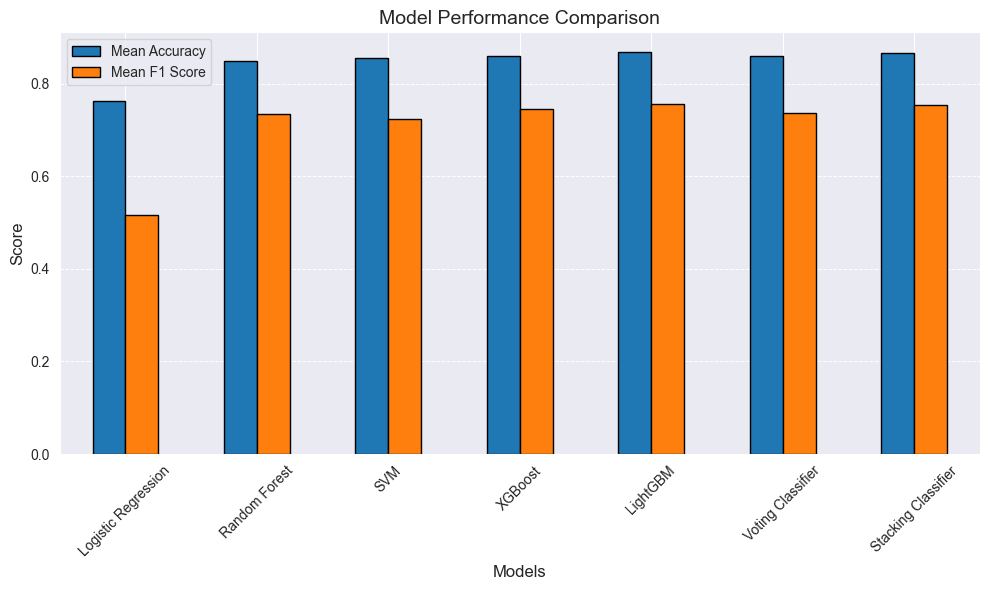

In [57]:
plot_metrics(results_df)

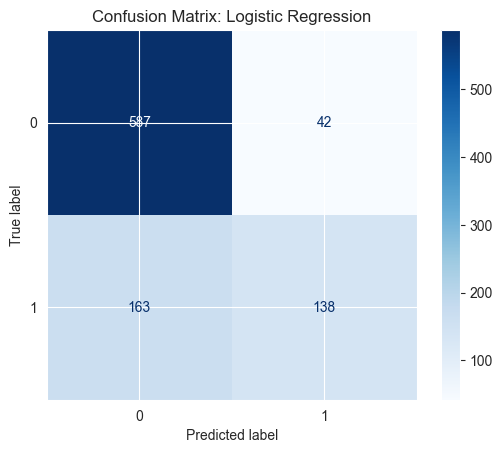

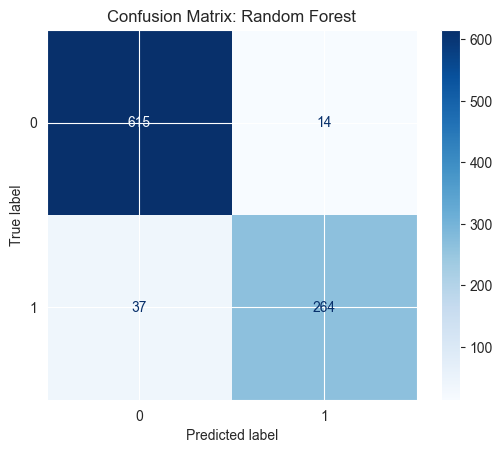

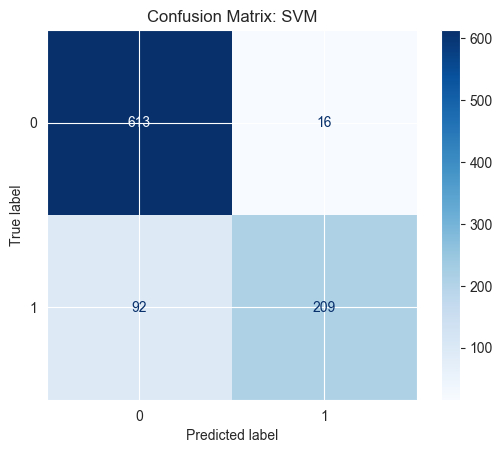

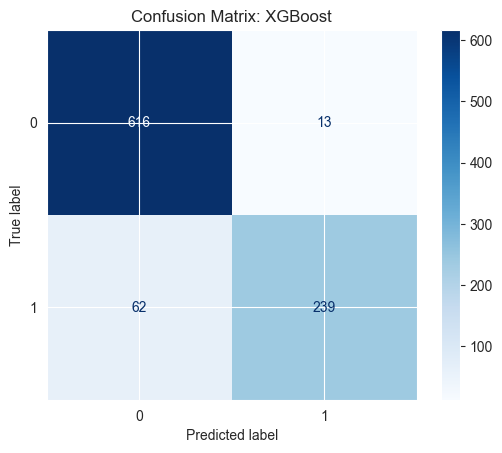

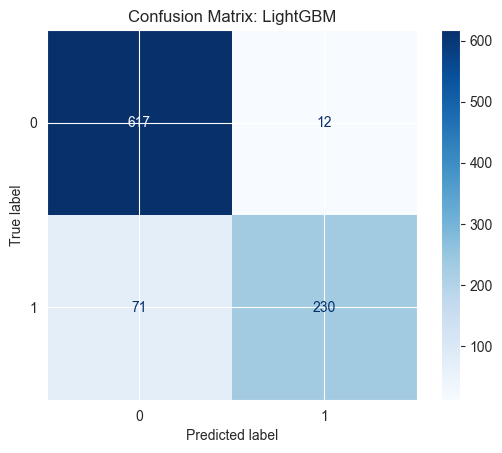

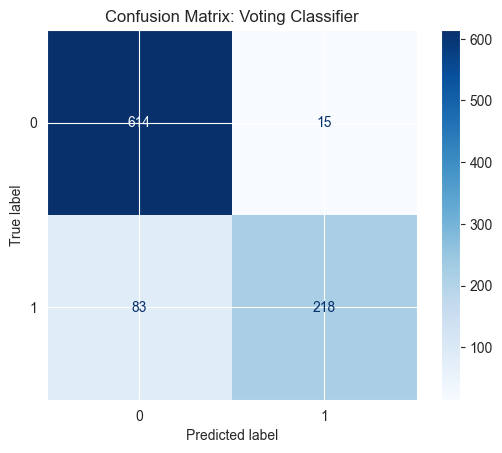

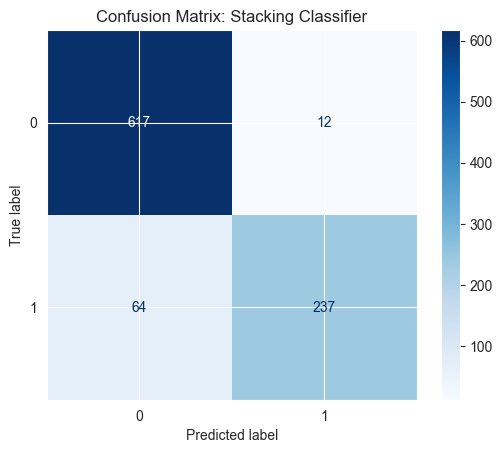

In [58]:
plot_confusion_matrices(models, X_test, y_test)